## Phase 2 : Exploration des données

In [1]:
# on commence par importer les dépendances dont on aura besoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import neighbors

sns.set()

### Quelques fonctions utilitaires

In [2]:
def check_multilinear_regression(data, columns): 
    """
    Renvoie lecoefficient R2 pour la regression linéaire
    
    Parameters
    ----------
    data: dataframe
    columns : colonnes à utiliser comme paramètre pour estimer le nutriscore
    
    Returns
    -------
    R2 : erreur de la regression
    regr : regression generator
    """
    cleaned_data = data.dropna(subset=columns, how='any')
    # on sépare en training set, en test set (80% pour le training)
    xtrain, xtest, ytrain, ytest = train_test_split(cleaned_data[columns], cleaned_data['computed nutriscore fr'], train_size=0.8)
    # on est obligé de reshape les valeurs de Y pour qu'elles soient utilisables par scikit learn
    ytrain= ytrain.values.reshape(-1, 1)
    ytest = ytest.values.reshape(-1, 1)
    regr = linear_model.LinearRegression()
    # on effectue notre régression linéaire
    regr.fit(xtrain, ytrain)
    # On renvoie le coefficient R2
    return regr.score(xtest, ytest), regr

### importation des données

In [3]:
food_data = pd.read_feather('P3_cleaned.feather')
food_data.head()

,index,code,product_name,nutriscore_grade,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g,carbs_no_sugar_100g,fat_non_satu_100g,computed nutriscore fr
0,806878,5425021250251,Filet de poulet sauce Chakchouka,None,481.0,1.204046,2.006743,0.0,23.679563,1.268261,1.0,58.195537,13.645850,70.909091
1,452448,327016058755,Fondant au Chocolat Surgelé,None,1732.0,22.085036,44.170072,0.0,8.834014,0.065212,22.0,13.803148,11.042518,32.727273
2,440376,3263851538918,Pointes d'asperges,None,67.0,0.000000,32.837750,0.0,46.520147,9.696186,-3.0,10.945917,0.000000,78.181818
3,521263,3428420053203,"Buche Creme au beurre, parfum chocolat",None,1594.0,19.203927,50.225655,0.0,6.795236,0.139580,22.0,11.817801,11.817801,32.727273
4,137120,010430652874676217,"Hackfleisch vom Rind und Schwein gemischt, zum...",None,1046.0,22.589452,0.000000,0.0,47.280248,0.186143,11.0,0.000000,29.944157,52.727273


### Analyse univariée du nutriscore

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B20764CC8>]],
      dtype=object)

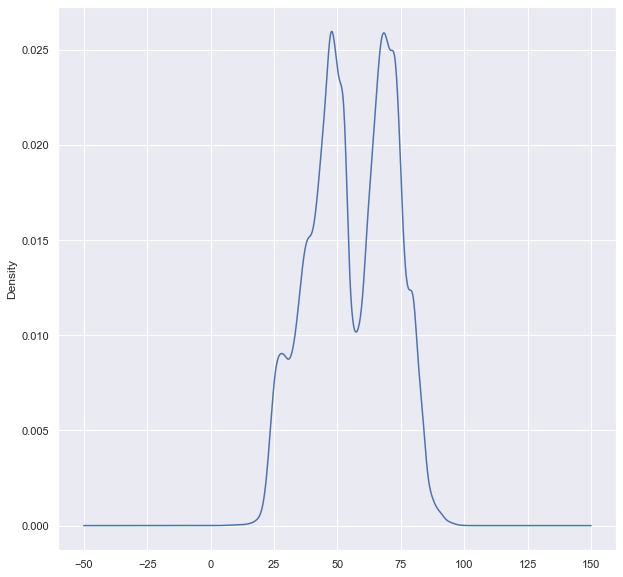

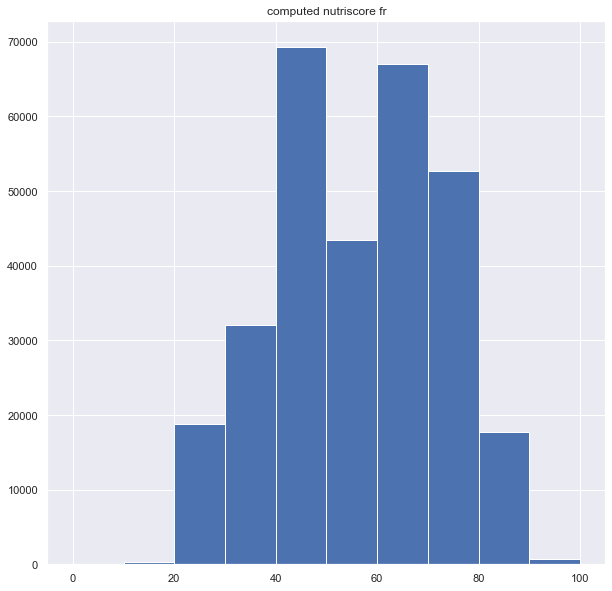

In [4]:
# On commence par voir notre nutriscore calculé (une note sur 100) pour trouver si ça correspond à une loi normale
food_data['computed nutriscore fr'].plot.kde(figsize=[10, 10])
food_data.hist(column='computed nutriscore fr', figsize=[10, 10])

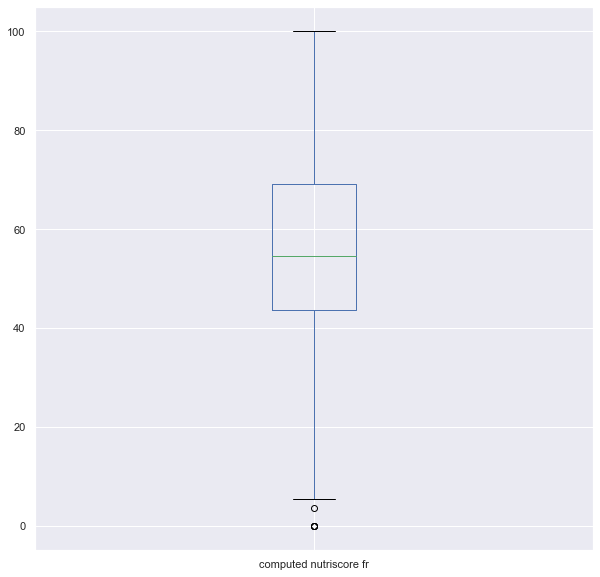

In [5]:
# à priori ça n'a pas l'air d'une gaussienne
food_data.boxplot(column='computed nutriscore fr', figsize=[10, 10])

In [6]:
food_data['computed nutriscore fr'].describe()

count    302131.000000
mean         55.858750
std          15.987899
min           0.000000
25%          43.636364
50%          54.545455
75%          69.090909
max         100.000000
Name: computed nutriscore fr, dtype: float64

In [7]:
# on va faire un test de Sharpiro Wil pour vérifier cette hypothèse
# Notre hypothèse H0 est que notre échantillon suit une loi normale, contre H1, il la suit pas
shapiro(food_data['computed nutriscore fr'])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.973542332649231, 0.0)

In [8]:
# On a un warning comme quoi la p Value n'est pas précise pour un échantillon aussi grand
# Utilisons un test de Kolmogrov Smirnov
kstest(food_data['computed nutriscore fr'], cdf='norm')

KstestResult(statistic=0.9999834263380605, pvalue=0.0)

In [9]:
# la p Value étant de 0, on peut rejeter la normalité de la loi

### Analyse multivariée avec les différents paramètres

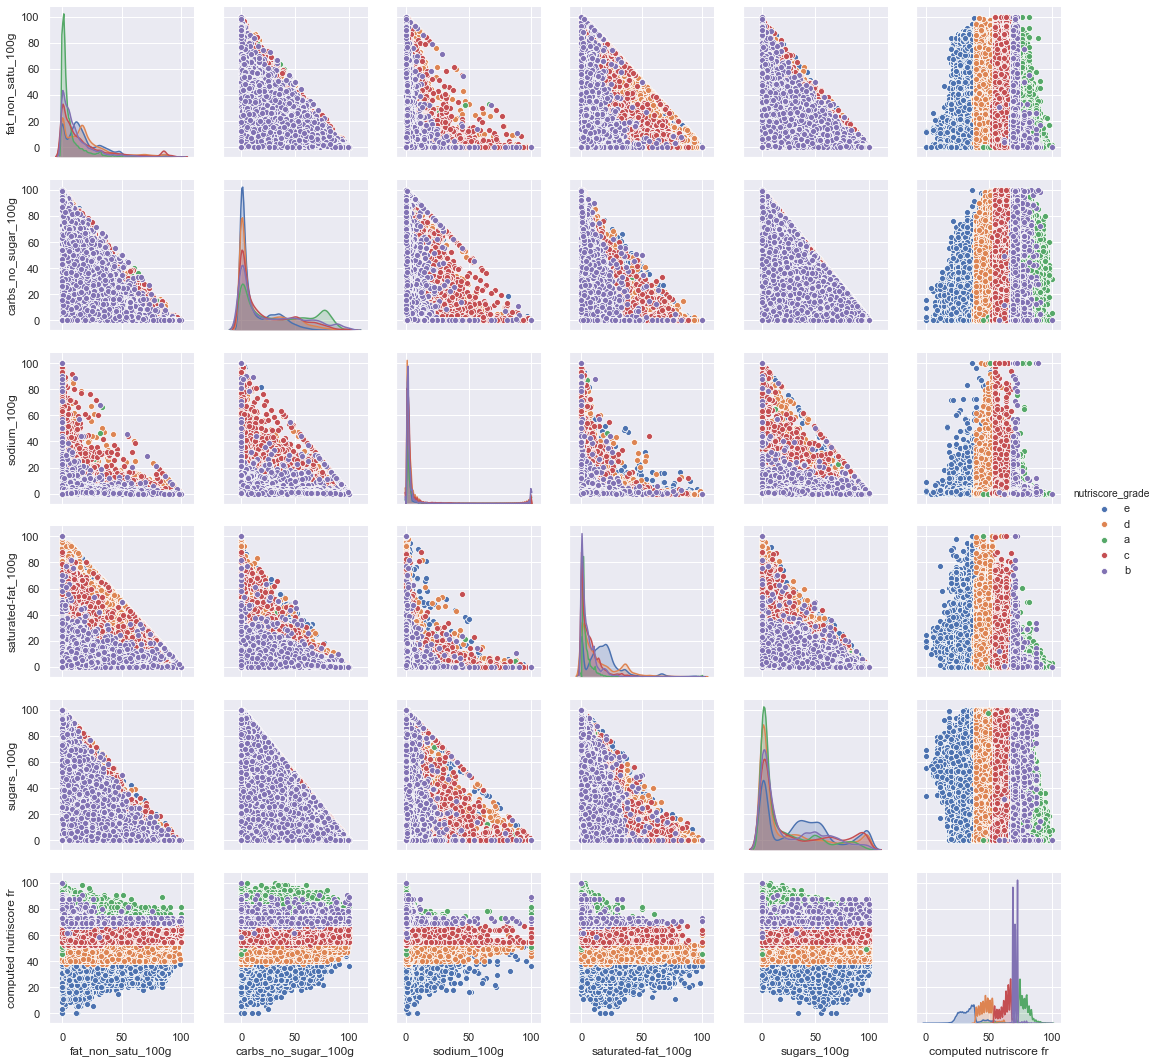

In [10]:
# Essayons de trouver des corrélations visuellement
subset = ['fat_non_satu_100g', 'carbs_no_sugar_100g', 'sodium_100g', 'saturated-fat_100g', 'sugars_100g', 'computed nutriscore fr', 'nutriscore_grade']
sns.pairplot(food_data[subset], hue='nutriscore_grade')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


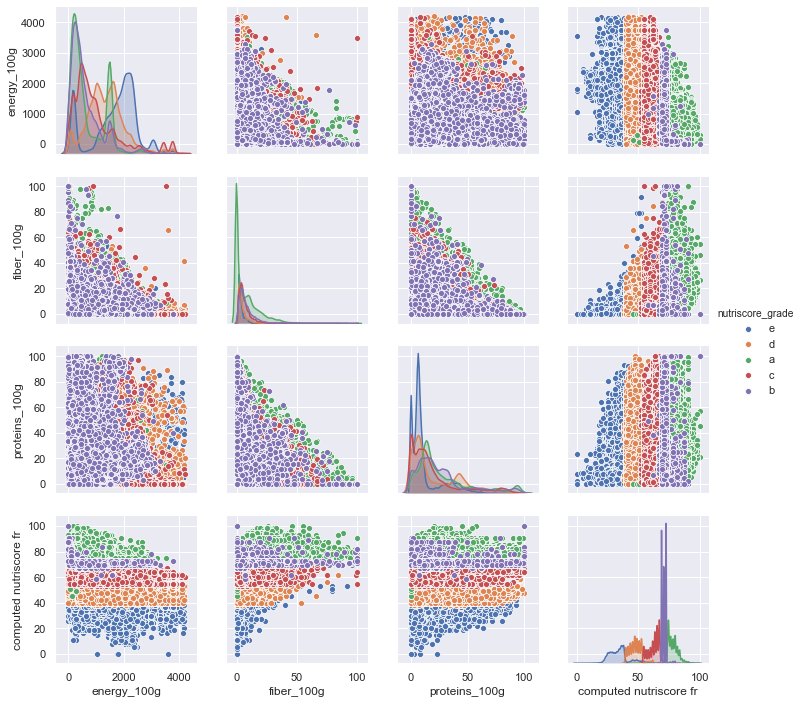

In [11]:
subset = ['energy_100g', 'fiber_100g', 'proteins_100g', 'computed nutriscore fr', 'nutriscore_grade']
sns.pairplot(food_data[subset], hue='nutriscore_grade')

In [29]:
# on n'observe pas de relation évidente, entre le nutriscore et un autre ingrédient
# on effectue une regression linéaire en utilisant que les ingrédients pour voir si on peut estimer le nutriscore
axes = ['saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'carbs_no_sugar_100g', 'fat_non_satu_100g']
# on sépare en training set, en test set (80% pour le training)
R2, regr = check_multilinear_regression(food_data, axes)
print('Coefficient R2 = %.2f' %R2 )

Coefficient R2 = 0.39


In [30]:
axes.append('energy_100g')
R2, regr = check_multilinear_regression(food_data, axes)
for i,j in zip(axes, regr.coef_[0]):
    print('Coefficient %s =  %.2f' % (i, j))
print('Coefficient R2 = %.2f' %R2 )

Coefficient saturated-fat_100g =  -0.38
Coefficient sugars_100g =  -0.11
Coefficient fiber_100g =  0.50
Coefficient proteins_100g =  0.04
Coefficient sodium_100g =  -0.17
Coefficient carbs_no_sugar_100g =  0.07
Coefficient fat_non_satu_100g =  0.04
Coefficient energy_100g =  -0.01
Coefficient R2 = 0.55


### Analyse du nutriscore grade

In [14]:
# on a aussi des information sur lel nutriscore grade, essayons de voir si ça correspond au nutriscore 
# On a besoin en première étape de convertir les scores en nombres, on va affecter à a le plus haut score (4) et à e le plus bas (0)
nutriscore_grade_to_score = {'a':4,'b':3,'c':2,'d':1,'e':0}
food_data['computed nutrition grade'] = food_data['nutriscore_grade'].replace(nutriscore_grade_to_score)

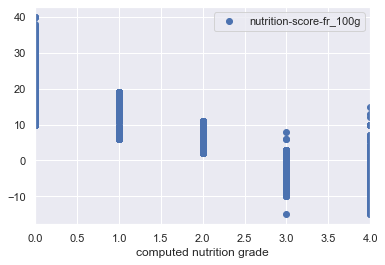

In [15]:
food_data.plot(x='computed nutrition grade', y='nutrition-score-fr_100g', style='o')

In [16]:
# à priori le nutriscore grade et le nutriscore score se chauvaucchent sur pas mal de points

In [33]:
# on fait un test du chi2 pour voir so mes variables sont corrélées
X = "computed nutrition grade"
Y = "computed nutriscore fr"
nutriscore_data=food_data[[X, Y]]
nutriscore_data.dropna(inplace=True)
cont = nutriscore_data.pivot_table(index=X, columns=Y, aggfunc=len).fillna(0).copy().astype(int)
st_chi2, st_p, st_dof, st_exp = chi2_contingency(cont)

print('Stat du chi2 = {chi2}, degrès de liberté = {deg}, P value = {p}'.format(p=st_p, chi2=st_chi2, deg=st_dof))

Stat du chi2 = 1081438.1309873136, degrès de liberté = 216, P value = 0.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [31]:
# Essayons de voir si les données sont corrélées en calculant la corrélation linéaire de pearson

print('Corrélation = %0.2f' % (food_data['computed nutrition grade'].corr(food_data['computed nutriscore fr'], method='pearson')))

Corrélation = 0.94


In [18]:
# les données semblent bien corrélées, donc on peut partir sur l'analyse du nutriscore grade
# On utilise un knn pour essayer d'estimer le nutriscore grade pour un ingrédient donné
cleaned_data = food_data.dropna(how='any')
# on sépare en training set, en test set (80% pour le training)
xtrain, xtest, ytrain, ytest = train_test_split(cleaned_data[axes], cleaned_data['nutriscore_grade'], train_size=0.8)

# on va commencer par un k = 3
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)
err = 1 - knn.score(xtest, ytest)
print('Erreur: %.2f' % err)

Erreur: 0.25


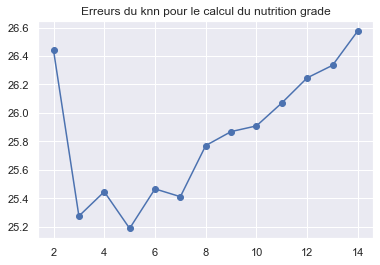

In [19]:
# on a 75 % d'erreurs, essayons de trouver un meilleur 'k' 
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.title('Erreurs du knn pour le calcul du nutrition grade')
plt.show()

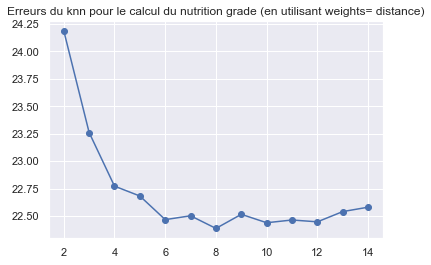

In [20]:
# on utilisant le paramètres weights='distance', le Knn accorde plus de poid aux points les plus proches, on pourra donc essayer avec celui là 
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k, weights='distance')
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.title('Erreurs du knn pour le calcul du nutrition grade (en utilisant weights= distance)')
plt.show()

In [23]:
knn = neighbors.KNeighborsClassifier(n_neighbors=8, weights='distance')
knn.fit(xtrain, ytrain)
err = 1 - knn.score(xtest, ytest)
print('Erreur: %0.2f' % err)  

Erreur: 0.22


In [24]:
# on va voir à quel point on s'est trompé, pour celà on va essayer de calculer la distance entre ce qu'on a prédit 
# et le vrai résultat
predicted = knn.predict(xtest)
prediction_errors = [];
for i,j in zip(ytest, predicted):
    prediction_errors.append(abs(nutriscore_grade_to_score.get(i) - nutriscore_grade_to_score.get(j)))

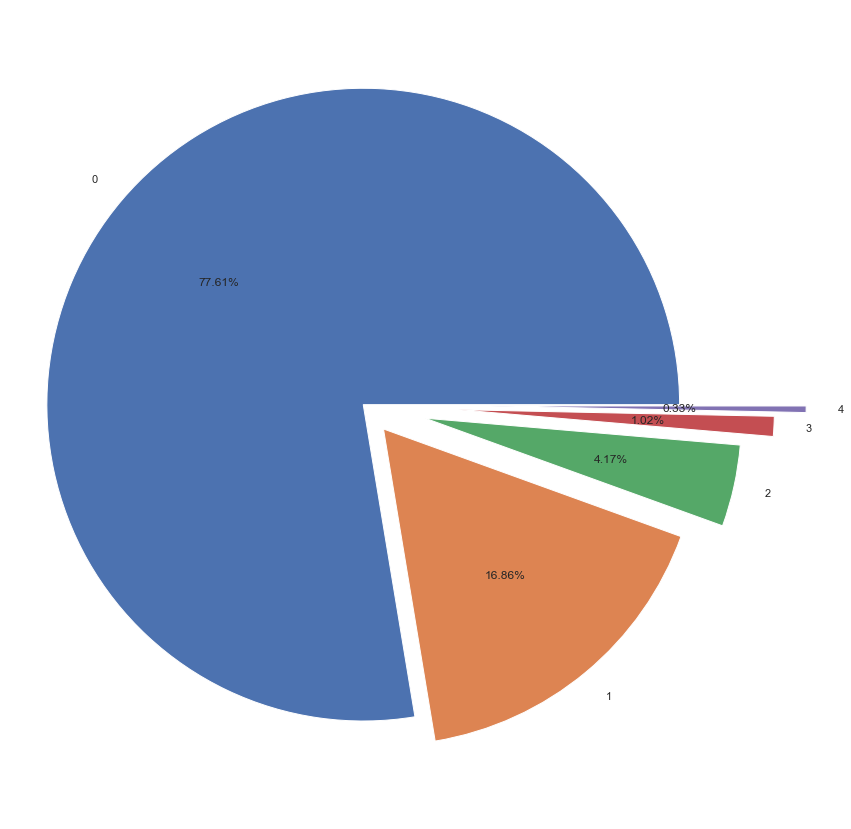

<Figure size 216x288 with 0 Axes>

In [25]:
labels = sorted(list(set(prediction_errors))) # on récupère toutes les valeurs possibles des predictions triées 
sizes = [prediction_errors.count(i) for i in labels] # on récupère le nombre d'occurences par erreur
explode = [i * 0.1 for i  in labels]

fig, ax1 = plt.subplots(figsize=(15,15))
plt.figure(figsize=(3,4))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

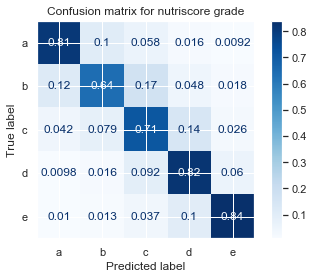

In [26]:
# On affiche la matrice de confusion qui serait plus clair pour ce cas
disp = plot_confusion_matrix(knn, xtest, ytest,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Confusion matrix for nutriscore grade')

plt.show()